In [1]:
obj_dims = (648, 486)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers


import os
import json
import scipy.io as sio
from os import path

from src.model import UNet_2d

import PIL
from PIL import Image

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [4]:
model_description = 'model-10.1'

In [5]:
real_data_path = path.join('..', 'data', 'real-data', 'realData.mat')
ground_truth_path = path.join('..', 'data', 'real-data', 'beads_GT.png')

real_res_target_path = '../data/real-data/res_target_z1.tif'

# Paths for saving/loading model weights, predictions
base_path = path.join('..', 'models', model_description)
model_weights_path = path.join(base_path, model_description)
image_path = path.join(base_path, 'prediction-images')

# Testing

In [18]:
model = UNet_2d()
epoch = 'best'
model.load_weights(model_weights_path + '.{}'.format(epoch))

In [19]:
# Read in older mat files with scipy.io
data = sio.loadmat(real_data_path)

In [20]:
def normalize(x):
    b = np.max(x)
    a = np.min(x)
    return (x - a) / (b - a)

In [21]:
beads, res = data['beads'], data['resTarget']
beads = np.array(Image.fromarray(beads).resize(obj_dims, resample=PIL.Image.NEAREST))
beads_input_normed = normalize(beads).T
beads_input = beads_input_normed.astype(np.float16)[np.newaxis, ..., np.newaxis]

In [22]:
# res = np.array(Image.fromarray(res).resize(obj_dims, resample=PIL.Image.NEAREST))
# res_input_normed = normalize(res).T
# res_input = res_input_normed.astype(np.float16)[np.newaxis, ..., np.newaxis]

In [23]:
# Load in real res target data
real_res = np.array(Image.open(real_res_target_path).resize(obj_dims, resample=PIL.Image.NEAREST))
real_res_normed = normalize(real_res).T
real_res_input = real_res_normed.astype(np.float16)[np.newaxis, ..., np.newaxis]

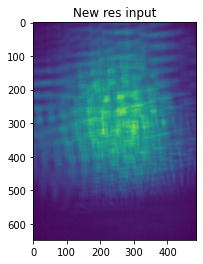

In [24]:
plt.figure()
plt.imshow(real_res_normed)
plt.title('New res input')
plt.show()

In [25]:
pred_beads = model.predict(beads_input).squeeze()

In [26]:
pred_res_real = model.predict(real_res_input).squeeze()

In [27]:
beads_gt_im = Image.open(ground_truth_path)
beads_gt = np.array(beads_gt_im).T
# Normalize beads from 0 to 1
beads_gt = (beads_gt - np.min(beads_gt)) / (np.max(beads_gt) - np.min(beads_gt))

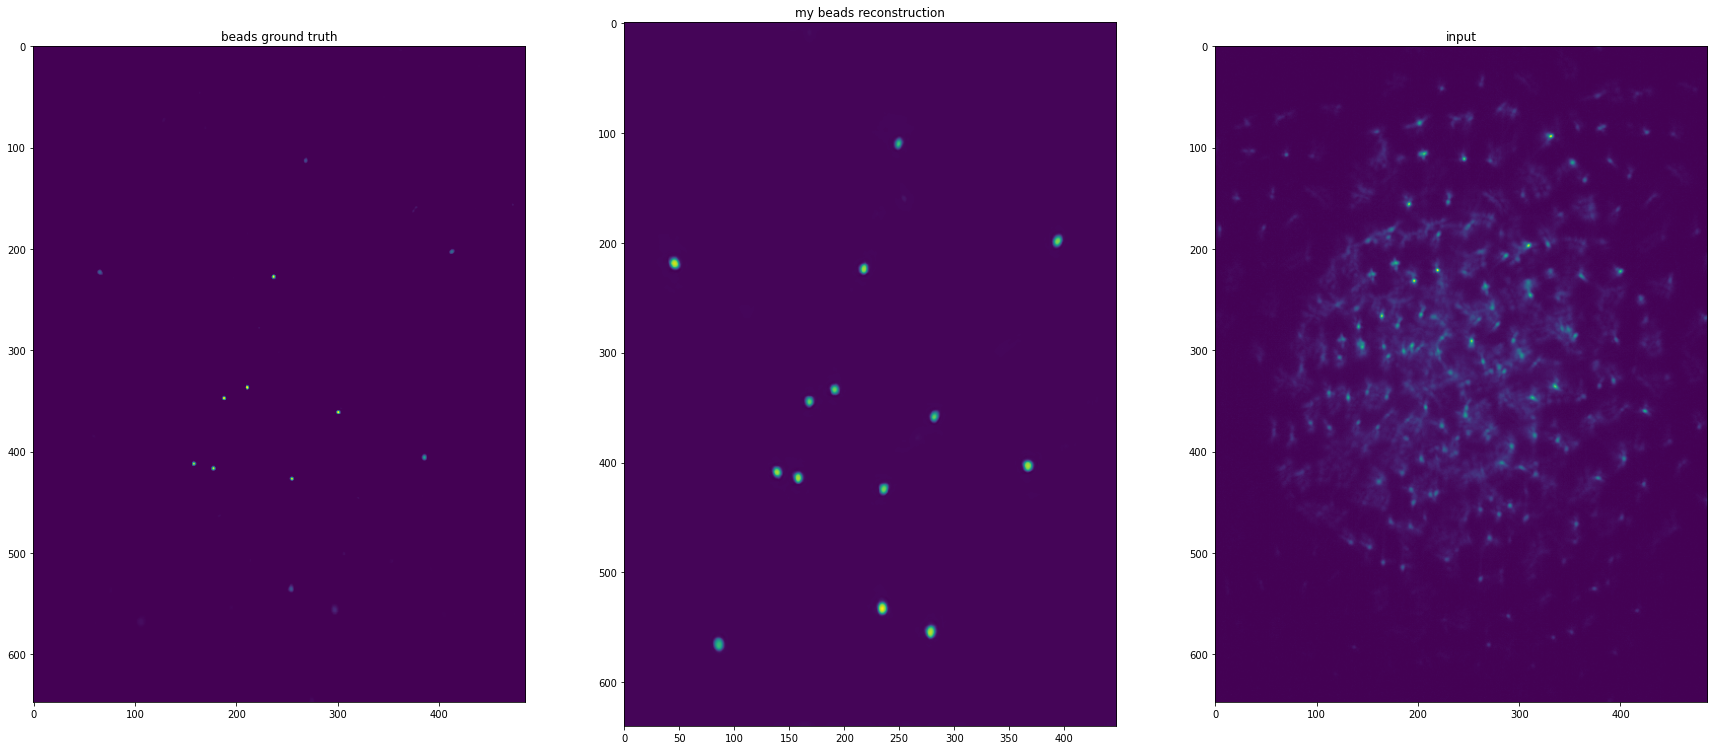

In [28]:
fig = plt.figure(figsize=(30, 30))
f0 = fig.add_subplot(1, 3, 1)
f0.set_title('beads ground truth')
f0.imshow(beads_gt)

f1 = fig.add_subplot(1, 3, 2)
f1.set_title('my beads reconstruction') # Normalized before simulation, but not after
f1.imshow(pred_beads)

f2 = fig.add_subplot(1, 3, 3)
f2.set_title('input')
f2.imshow(beads_input_normed)


plt.savefig(path.join(image_path, '{}_beads_reconstruction_{}.pdf'.format(model_description, epoch)))
plt.show()


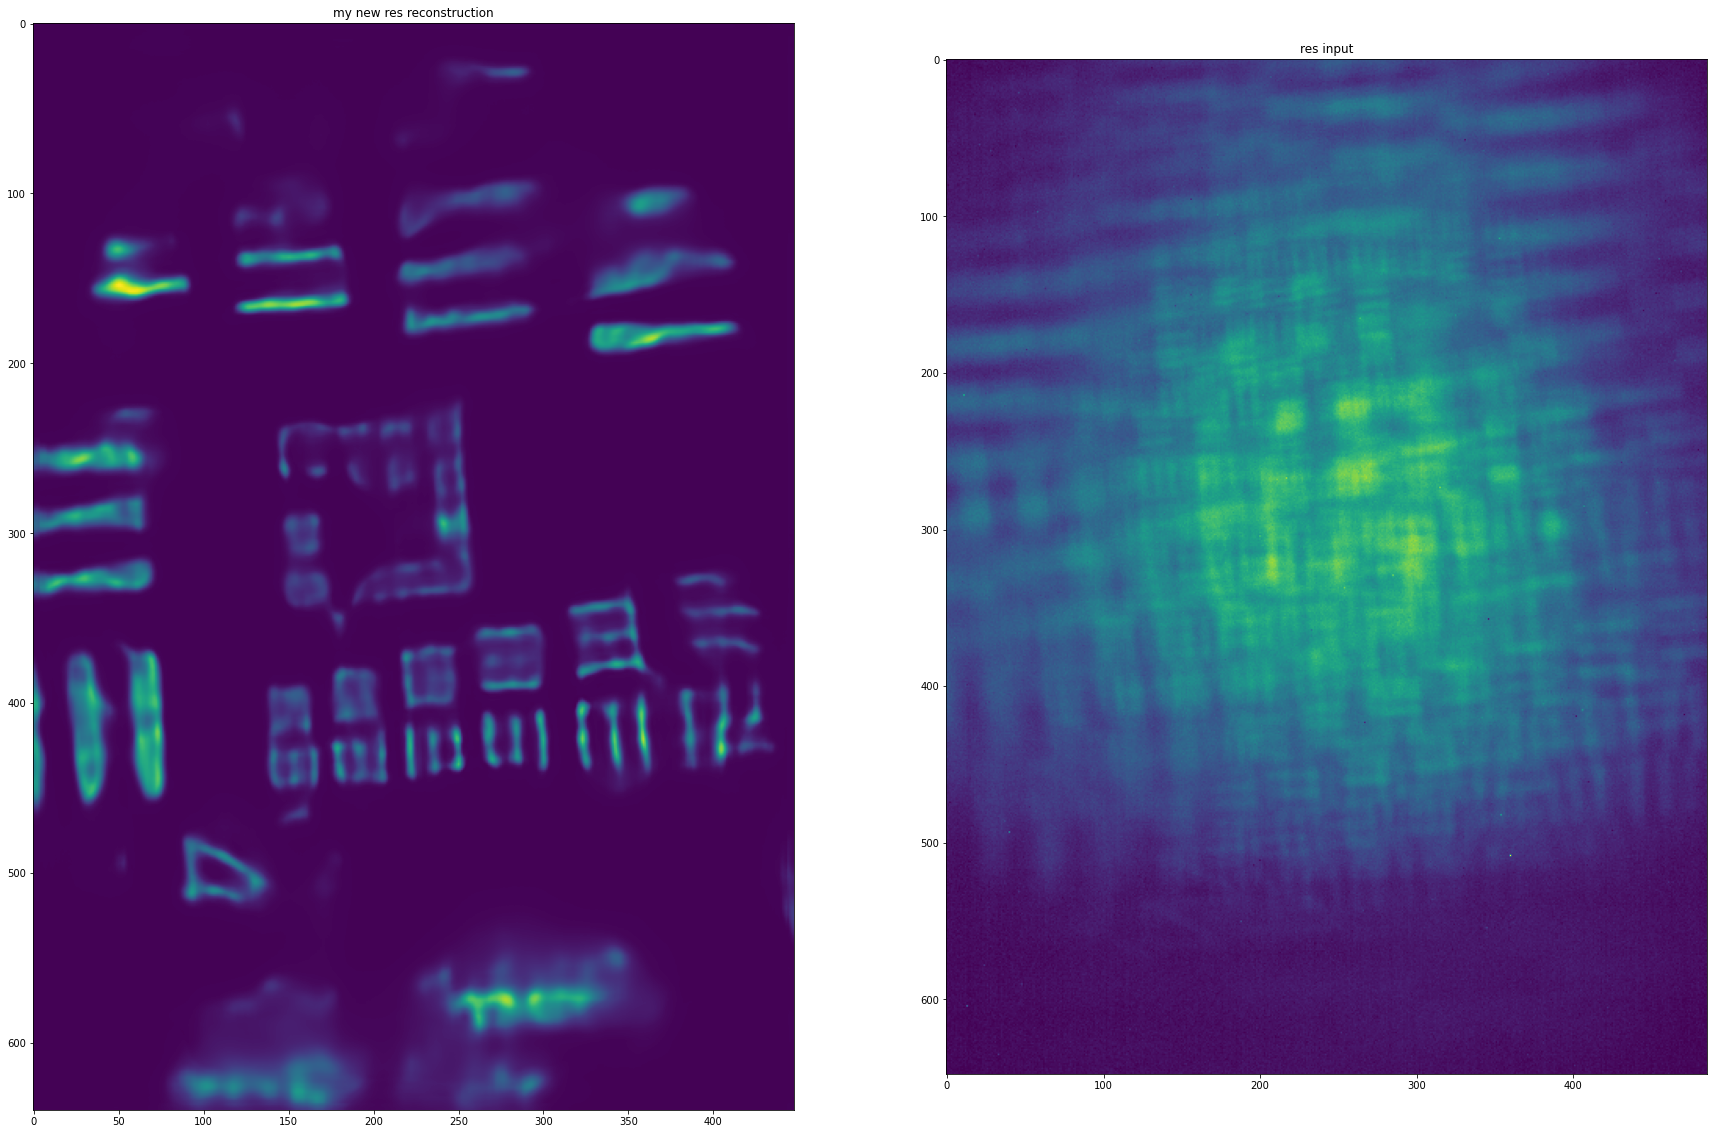

In [29]:
fig = plt.figure(figsize=(30, 30))


f1 = fig.add_subplot(1, 2, 1)
f1.set_title('my new res reconstruction') # Normalized before simulation, but not after
f1.imshow(pred_res_real)

f3 = fig.add_subplot(1, 2, 2)
f3.set_title('res input')
f3.imshow(real_res_normed)


plt.savefig(path.join(image_path, '{}_res_reconstruction_{}.pdf'.format(model_description, epoch)))

plt.show()